## Bank Customer Churn Prediction

In [58]:
!pip install catboost


In [59]:
# loading necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score,recall_score
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV


In [60]:
df = pd.read_csv("BankCustomerData.csv")

# Exploratory Data Analysis

In [61]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [62]:
df.shape

(10000, 12)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [64]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [65]:
categorical_variables = [col for col in df.columns if col in "object"
                        or df[col].nunique() <=11
                        and col not in "exit"]

categorical_variables

['country',
 'gender',
 'tenure',
 'products_number',
 'credit_card',
 'active_member',
 'churn']

In [66]:
numeric_variables = [col for col in df.columns if df[col].dtype != "object"
                        and df[col].nunique() >11
                        and col not in "customer_id"]
numeric_variables

['credit_score', 'age', 'balance', 'estimated_salary']

In [67]:
df["churn"].value_counts()

,count
churn,
0,7963
1,2037


In [68]:
exit = df.loc[df["churn"]==1]
not_exit = df.loc[df["churn"]==0]

In [69]:
not_exit.shape
#exit.shape

(7963, 12)

In [70]:
def get_sorted_value_counts(df, column_name):
    return df[column_name].value_counts().sort_values()

print('Tenure frequency of the exited and not exited groups')
print(get_sorted_value_counts(not_exit, "tenure"))
print(get_sorted_value_counts(exit, "tenure"))

print('Number of products frequency of the exited and not exited groups')
print(get_sorted_value_counts(not_exit, "products_number"))
print(get_sorted_value_counts(exit, "products_number"))

print('credit card frequency of the exited and not exited groups')
print(get_sorted_value_counts(not_exit, "credit_card"))
print(get_sorted_value_counts(exit, "credit_card"))

print('If active based frequency of the exited and not exited groups')
print(get_sorted_value_counts(not_exit, "active_member"))
print(get_sorted_value_counts(exit, "active_member"))

print('country frequency of the exited and not exited groups')
print(get_sorted_value_counts(not_exit, "country"))
print(get_sorted_value_counts(exit, "country"))

print('gender frequency of the exited and not exited groups')
print(get_sorted_value_counts(not_exit, "gender"))
print(get_sorted_value_counts(exit, "gender"))


Tenure frequency of the exited and not exited groups
tenure
0     318
10    389
9     771
6     771
4     786
3     796
5     803
1     803
8     828
2     847
7     851
Name: count, dtype: int64
tenure
0      95
10    101
7     177
6     196
8     197
2     201
4     203
5     209
3     213
9     213
1     232
Name: count, dtype: int64
Number of products frequency of the exited and not exited groups
products_number
3      46
1    3675
2    4242
Name: count, dtype: int64
products_number
4      60
3     220
2     348
1    1409
Name: count, dtype: int64
credit card frequency of the exited and not exited groups
credit_card
0    2332
1    5631
Name: count, dtype: int64
credit_card
0     613
1    1424
Name: count, dtype: int64
If active based frequency of the exited and not exited groups
active_member
0    3547
1    4416
Name: count, dtype: int64
active_member
1     735
0    1302
Name: count, dtype: int64
country frequency of the exited and not exited groups
country
Germany    1695
Spain   

In [71]:
print(exit.columns.tolist())


['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'churn']


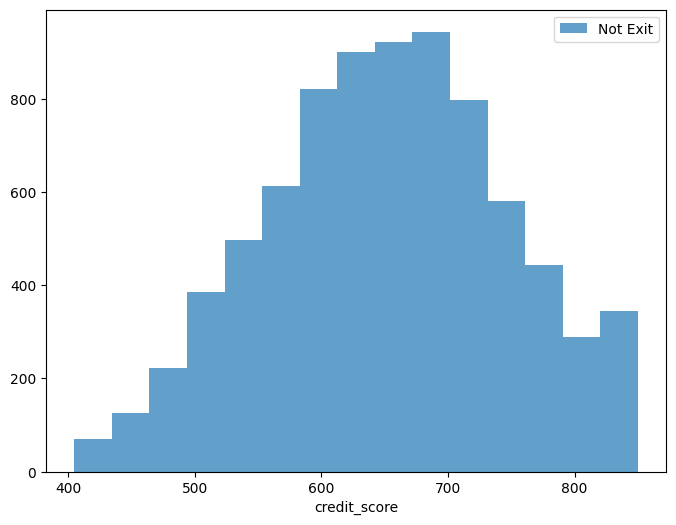

In [72]:
# distribution of the Credit Score for not_exit
pyplot.figure(figsize=(8,6))
pyplot.xlabel('credit_score')
pyplot.hist(not_exit["credit_score"],bins=15, alpha=0.7, label='Not Exit')
pyplot.legend(loc='upper right')
pyplot.show()

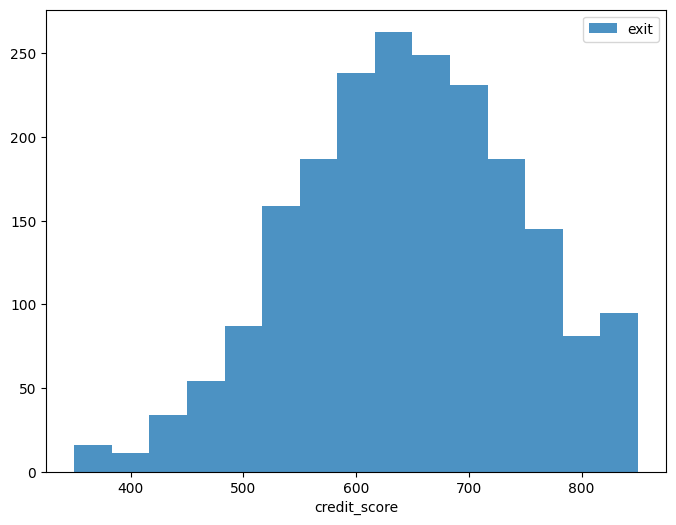

In [73]:
# distribution of the Credit Score for exit
pyplot.figure(figsize=(8,6))
pyplot.xlabel('credit_score')
pyplot.hist(exit["credit_score"],bins=15, alpha=0.8, label='exit')
pyplot.legend(loc='upper right')
pyplot.show()

Notice that the credit score distributions for both "Not Exit" and "Exit" groups overlap significantly. **This suggests that credit score alone is likely not a strong predictor of customer churn.** *Customers with good, average, and even less-than-ideal credit scores can be found in both groups.*

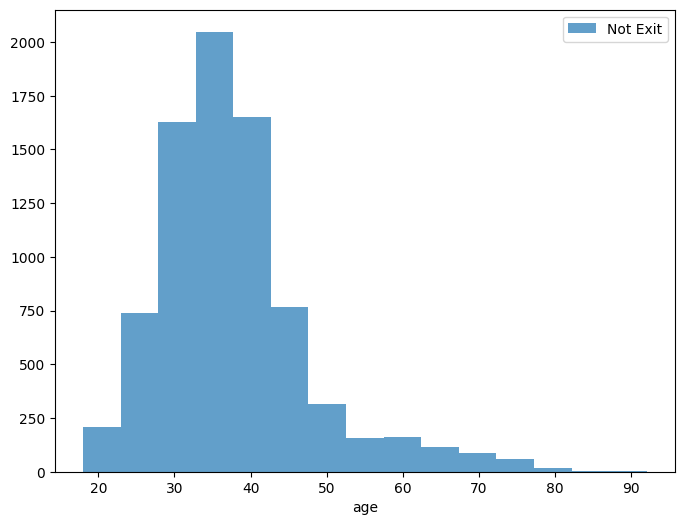

In [74]:
# distribution of the Age for not_exit
pyplot.figure(figsize=(8,6))
pyplot.xlabel('age')
pyplot.hist(not_exit["age"],bins=15, alpha=0.7, label='Not Exit')
pyplot.legend(loc='upper right')
pyplot.show()

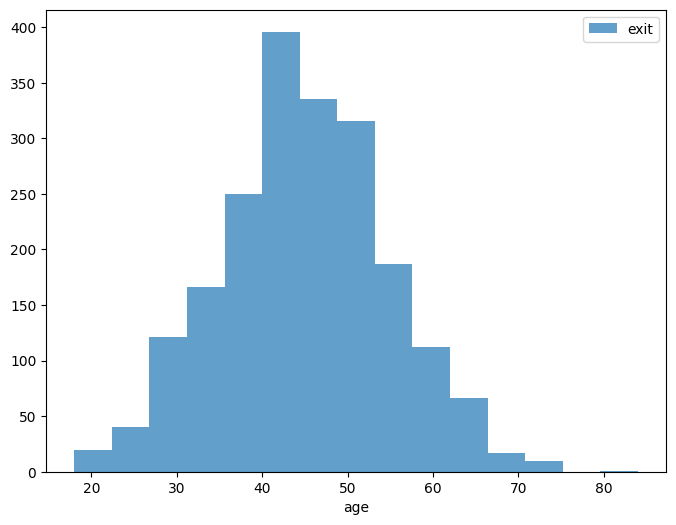

In [75]:
# distribution of the Age for exit
pyplot.figure(figsize=(8,6))
pyplot.xlabel('age')
pyplot.hist(exit["age"],bins=15, alpha=0.7, label='exit')
pyplot.legend(loc='upper right')
pyplot.show()

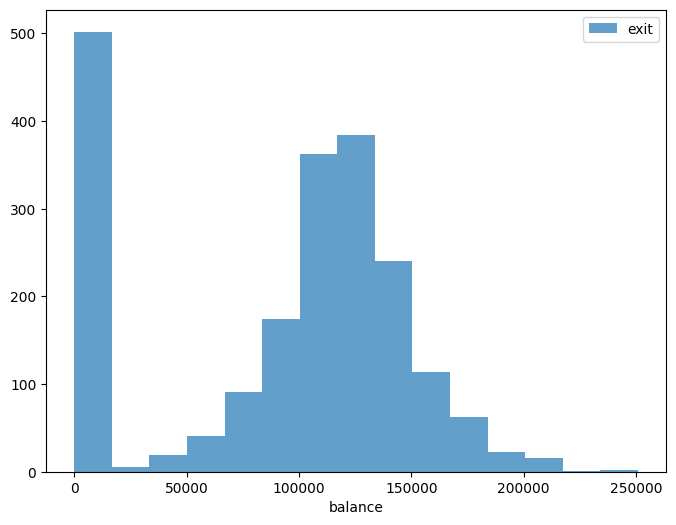

In [76]:
# distribution of the Balance for exit
pyplot.figure(figsize=(8,6))
pyplot.xlabel('balance')
pyplot.hist(exit["balance"],bins=15, alpha=0.7, label='exit')
pyplot.legend(loc='upper right')
pyplot.show()

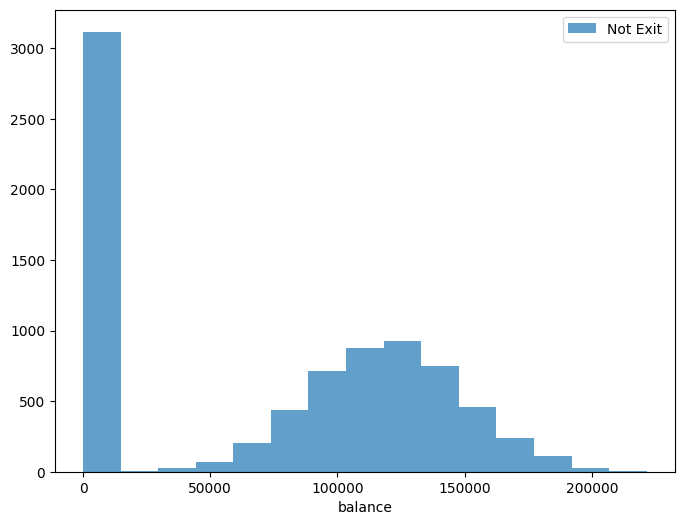

In [77]:
# distribution of the Balance for not_exit
pyplot.figure(figsize=(8,6))
pyplot.xlabel('balance')
pyplot.hist(not_exit["balance"],bins=15, alpha=0.7, label='Not Exit')
pyplot.legend(loc='upper right')
pyplot.show()

**No money = Likely to stay:** If people have almost no money in their account, they tend to stay with the bank.
**Good amount = Likely to stay:** People with a decent amount of money (around 100,000 to 150,000) also tend to stay.
**Small amount = More likely to leave:** If people have a small amount of money in their account (but not zero), they are more likely to leave the bank.
**Lots of money = Likely to stay**: People with very large amounts of money tend to stay, but there aren't many customers like this in the first place.

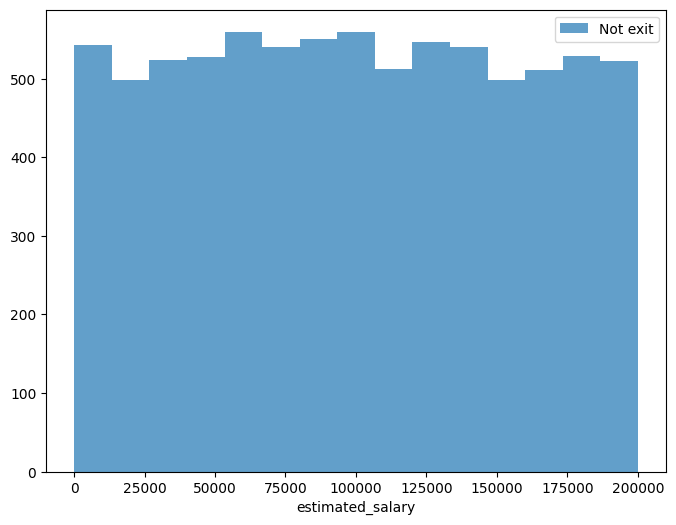

In [78]:
# distribution of the estimated_salary for exit
pyplot.figure(figsize=(8,6))
pyplot.xlabel('estimated_salary')
pyplot.hist(not_exit["estimated_salary"],bins=15, alpha=0.7, label='Not exit')
pyplot.legend(loc='upper right')
pyplot.show()

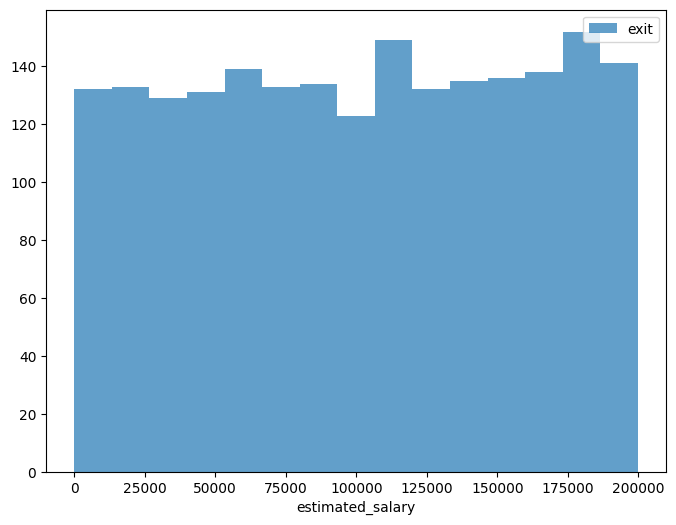

In [79]:
# distribution of the estimated_salary for exit
pyplot.figure(figsize=(8,6))
pyplot.xlabel('estimated_salary')
pyplot.hist(exit["estimated_salary"],bins=15, alpha=0.7, label='exit')
pyplot.legend(loc='upper right')
pyplot.show()

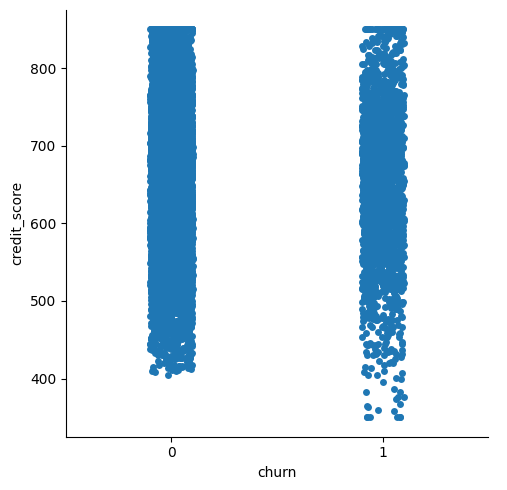

In [80]:
sns.catplot(x="churn", y="credit_score", data = df)

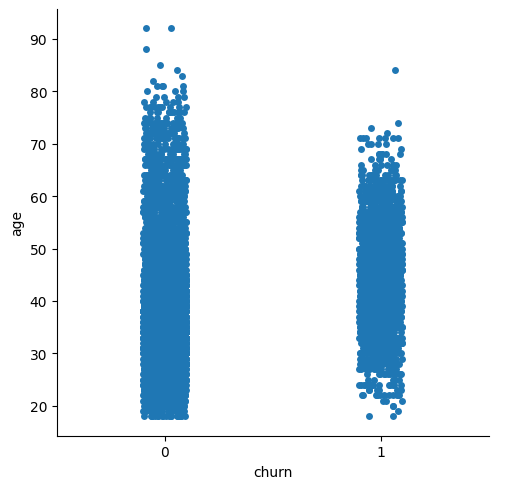

In [81]:
sns.catplot(x="churn", y="age", data = df)

People of all ages leave the bank. It's not just the very old or the very young. While there might be a slight tendency for younger people to leave a bit more often than some middle-aged people, and some older people do leave **thus, age alone isn't a strong predictor of who will leave the bank. **

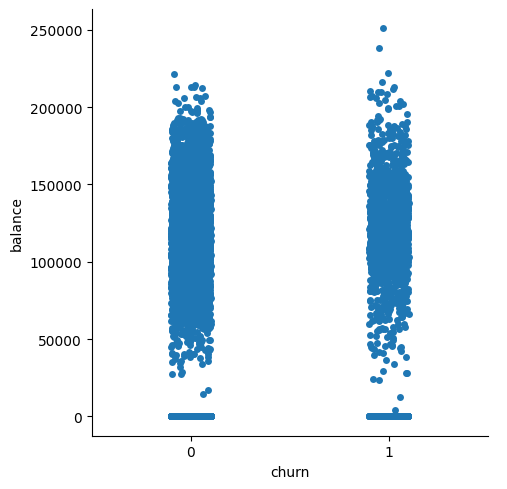

In [82]:
sns.catplot(x="churn", y="balance", data = df)

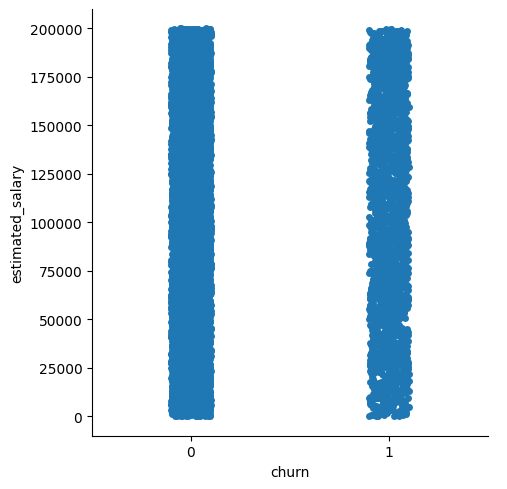

In [83]:
sns.catplot(x="churn", y="estimated_salary", data = df)

This chart suggests that there is **no strong relationship between a customer's estimated salary** and whether they churn. People with high salaries are just as likely to leave as people with low salaries, and vice versa. **Salary doesn't seem to be a key factor in predicting customer churn based on this visualization alone.**

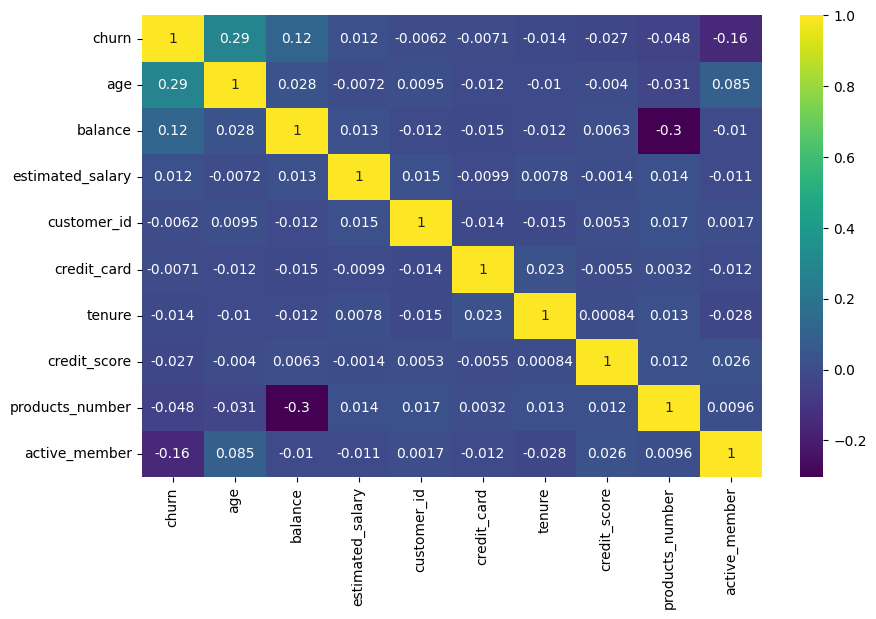

In [84]:
# churn correlation matrix
def plot_correlation_heatmap(df, k):
    # Select only numeric features for correlation calculation
    numeric_df = df.select_dtypes(include=np.number)
    cols = numeric_df.corr().nlargest(k, 'churn')['churn'].index
    cm = df[cols].corr()
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, cmap='viridis')


plot_correlation_heatmap(df, 10)

#Conclusion of HeatMap
1.   Older people are a bit more likely to leave.
2.   People with more money in their account are slightly more likely to leave.
3. Whether someone has a credit card, their salary, how long they've been a customer (tenure), or their credit score doesn't seem to have much of a direct impact on whether they leave.
4. People with more products with the bank are slightly less likely to leave.
Active members are less likely to leave.



# Data Preprocessing

In [85]:
df.isnull().sum()

,0
customer_id,0
credit_score,0
country,0
gender,0
age,0
tenure,0
balance,0
products_number,0
credit_card,0
active_member,0


There are no missing values in this dataset

In [86]:
for var in numeric_variables:
    low_quantile = 0.05 #instead of the conventional IQR (25th to 75th percentile), you're expanding it to be more inclusive (5th to 95th percentile).
    up_quantile = 0.95
    for col in [var]:
        quantile_one = df[col].quantile(low_quantile)
        quantile_three = df[col].quantile(up_quantile)
        interquantile_range = quantile_three - quantile_one
        up_limit = quantile_three + 1.5 * interquantile_range
        low_limit = quantile_one - 1.5 * interquantile_range

        outliers = (df[col] > up_limit) | (df[col] < low_limit)
        number_of_outliers = outliers.sum()
        if number_of_outliers > 0:
            print(col, ":", number_of_outliers, "outliers")
        else:
            print('No outliers')



No outliers
No outliers
No outliers
No outliers


In [95]:
print(df.columns.tolist())


Index(['credit_score', 'age', 'tenure', 'balance', 'products_number',
       'credit_card', 'active_member', 'estimated_salary', 'churn',
       'gender_Male', 'country_Germany', 'country_Spain'],
      dtype='object')


In [88]:
# Variables to apply one hot encoding
list = ["gender", "country"]
df = pd.get_dummies(df, columns =list, drop_first = True)

In [89]:
df.head()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,gender_Male,country_Germany,country_Spain
0,15634602,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,15647311,608,41,1,83807.86,1,0,1,112542.58,0,False,False,True
2,15619304,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,15701354,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,15737888,850,43,2,125510.82,1,1,1,79084.10,0,False,False,True


In [94]:
print(df.columns.tolist())


['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'churn', 'gender_Male', 'country_Germany', 'country_Spain']


# Scaling

In [90]:
df = df.drop(["customer_id"], axis = 1)

In [91]:
df

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,gender_Male,country_Germany,country_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,False,True
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,True,False,False
9996,516,35,10,57369.61,1,1,1,101699.77,0,True,False,False
9997,709,36,7,0.00,1,0,1,42085.58,1,False,False,False
9998,772,42,3,75075.31,2,1,0,92888.52,1,True,True,False


In [92]:
scaler = RobustScaler()
scaled_data = scaler.fit_transform(df)

# Modeling

In [96]:
X = df.drop("churn",axis=1)
y = df["churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [97]:
models = [('LR', LogisticRegression(random_state=42)),
          ('KNN', KNeighborsClassifier()),
          ('DT', DecisionTreeClassifier(random_state=42)),
          ('RF', RandomForestClassifier(random_state=42)),
          ('SVC', SVC(gamma='auto',random_state=42)),
          ('GB', GradientBoostingClassifier(random_state = 42)),
          ("LightGBM", LGBMClassifier(random_state=42))]
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X, y, cv=kfold)
    results.append(cv_results)
    names.append(name)
    output = "%s: %f " % (name, cv_results.mean())
    print(output)

/usr/local/lib/python3.11/dist-packages/joblib/parallel.py:1847: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  res = func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/joblib/parallel.py:1847: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  res = func(*args, **kwargs)
/usr/local/lib/pytho

LR: 0.791400 
KNN: 0.765000 
DT: 0.790100 
RF: 0.861300 
SVR: 0.796300 
GB: 0.864500 
[LightGBM] [Info] Number of positive: 1833, number of negative: 7167
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203667 -> initscore=-1.363533
[LightGBM] [Info] Start training from score -1.363533
[LightGBM] [Info] Number of positive: 1825, number of negative: 7175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 11
[Lig

In [99]:
def classifier_results(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred,zero_division=0)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)   #Needed for ROC-AUC, which requires probability
    print("Accuracy: {:.4f} Precision: {:.4f} Recall: {:.4f} F1: {:.4f} ROC-AUC: {:.4f}".format(accuracy,precision,recall,f1,roc_auc))
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(confusion, cmap = 'YlGnBu',annot = True, fmt='d')
    ax.set_title('Confusion Matrix')

    return confusion

In [100]:
def generate_auc_roc_curve(y_test,  y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

Accuracy: 0.8675 Precision: 0.7500 Recall: 0.4885 F1: 0.5917 ROC-AUC: 0.8729


array([[1543,   64],
       [ 201,  192]])

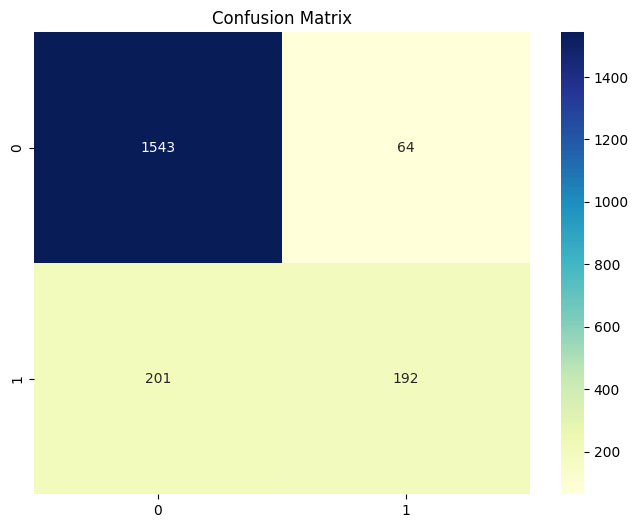

In [101]:
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
classifier_results(y_test, pred=y_pred, pred_proba=y_pred_proba)


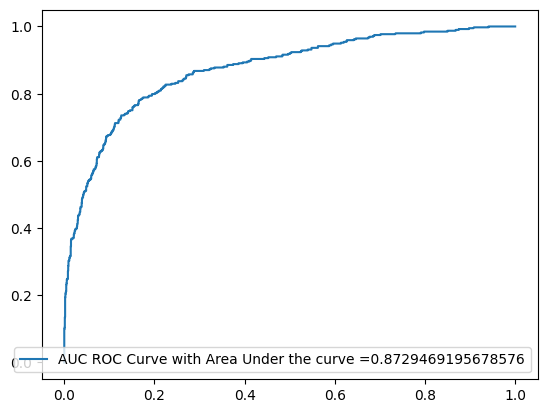

In [102]:
generate_auc_roc_curve(y_test,  y_pred_proba)

# Hyperparameter Tuning

In [104]:
def grid_search_cv(estimator, param_grid, cv=5, scoring='roc_auc'):
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, scoring=scoring)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_
#returns the set of hyperparameters that resulted in the best model performance (highest ROC-AUC score).

Lets tune the LGBMClassifier,GradientBoostingClassifier and RandomForestClassifier

In [105]:
#parameter grid
'''
n_estimators: The number of trees in the model.
learning_rate: The rate at which the model updates its parameters during training.
max_depth: The maximum depth of each tree in the ensemble.
'''
lgbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7]
}

gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7]
}

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}


In [106]:
lgbm = LGBMClassifier(random_state=42)
lgbm_best_params = grid_search_cv(lgbm, lgbm_param_grid)  #estimator = lgbm
print("Best parameters for LGBMClassifier:", lgbm_best_params)


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [107]:
gb = GradientBoostingClassifier(random_state=42)
gb_best_params = grid_search_cv(gb, gb_param_grid)
print("Best parameters for GradientBoostingClassifier:", gb_best_params)

Best parameters for GradientBoostingClassifier: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


In [108]:
rf = RandomForestClassifier(random_state=42)
rf_best_params = grid_search_cv(rf, rf_param_grid)
print("Best parameters for RandomForestClassifier:", rf_best_params)

Best parameters for RandomForestClassifier: {'max_depth': 7, 'n_estimators': 200}


[LightGBM] [Info] Number of positive: 1644, number of negative: 6356
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.205500 -> initscore=-1.352267
[LightGBM] [Info] Start training from score -1.352267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

array([[1547,   60],
       [ 206,  187]])

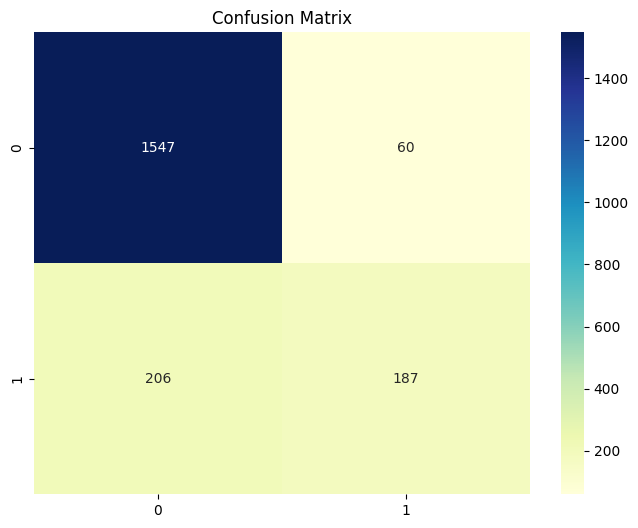

In [109]:
model1 = LGBMClassifier(learning_rate= 0.05, max_depth= 5, n_estimators= 100,random_state=42)
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)
y_pred_proba = model1.predict_proba(X_test)[:, 1]
classifier_results(y_test, pred=y_pred, pred_proba=y_pred_proba)


Accuracy: 0.8675 Precision: 0.7520 Recall: 0.4860 F1: 0.5904 ROC-AUC: 0.8731


array([[1544,   63],
       [ 202,  191]])

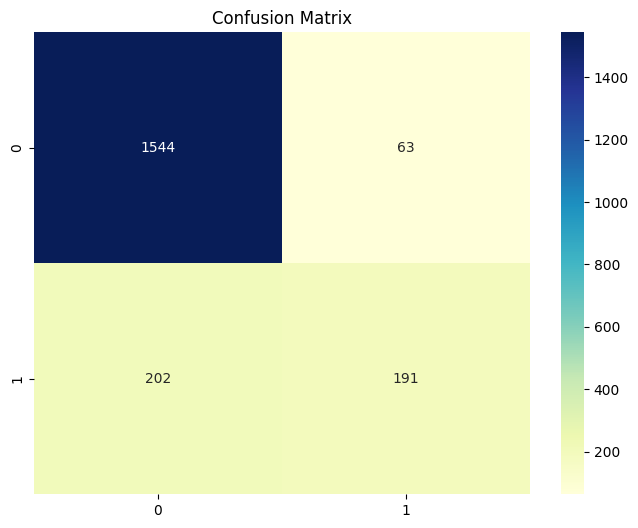

In [110]:
model2 = GradientBoostingClassifier(learning_rate= 0.05, max_depth= 3, n_estimators= 200,random_state=42)
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
y_pred_proba = model2.predict_proba(X_test)[:, 1]
classifier_results(y_test, pred=y_pred, pred_proba=y_pred_proba)


Accuracy: 0.8605 Precision: 0.7938 Recall: 0.3919 F1: 0.5247 ROC-AUC: 0.8685


array([[1567,   40],
       [ 239,  154]])

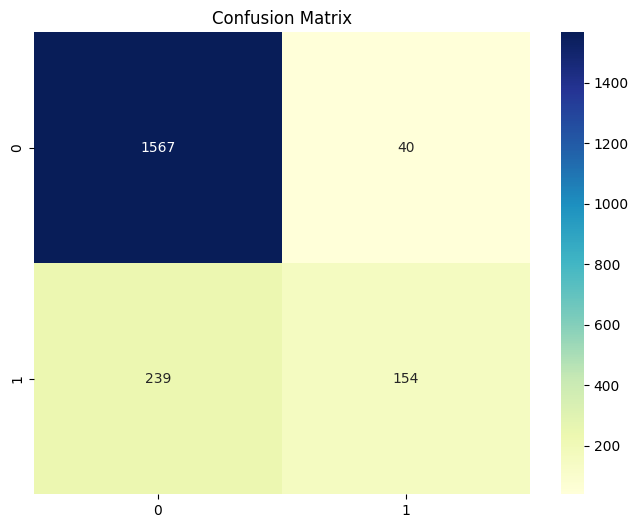

In [111]:
model3 = RandomForestClassifier(max_depth= 7, n_estimators= 200,random_state=42)
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
y_pred_proba = model3.predict_proba(X_test)[:, 1]
classifier_results(y_test, pred=y_pred, pred_proba=y_pred_proba)


# Conclusion

The Best model is LGBMClassifier model with a learning rate of 0.05, max depth of 5, and 100 estimators achieved an accuracy of 0.8670. It showed a precision of 0.7571, recall of 0.4758, and an F1 score of 0.5844. The model's ROC-AUC score was 0.8741, indicating good performance in distinguishing between positive and negative cases. Overall, the model demonstrated promising results, although further improvements can be made. Trialing wiht ensembles may result in better results